In [1]:
import sys
import os
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import cooler
from sklearn.decomposition import PCA
import glob

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# local imports
source_path = os.path.abspath("../../source/")
sys.path.append(source_path)
import utils as ut
import plotting as plt2
import hypercore as hc
import matrix as matrix
import centrality as central

# hyperlocal imports
import core_utils

# Get chromsizes

In [2]:
reload(core_utils)
# load chromsizes 
fpath = "/scratch/indikar_root/indikar1/shared_data/population/references/GRCm39.chrom.sizes"
chroms, chrom_starts = core_utils.load_chrom_sizes(fpath)
chroms.head()

,chrom,size,bp_start
0,1,195154279,0
1,2,181755017,195154279
2,3,159745316,376909296
3,4,156860686,536654612
4,5,151758149,693515298


# Load population pore-c

In [3]:
reload(core_utils)
    
dpath = "/scratch/indikar_root/indikar1/shared_data/population/align_table/"
resolution = 1e6 
chromosomes = ['2']
df = core_utils.load_population_pore_c(dpath, chrom_starts, resolution=resolution, chroms=chromosomes)
print(f"{df.shape=}")
df['ones'] = 1
df.head()

batch04 (177353, 8)
batch02 (18558, 8)
batch03 (92905, 8)
batch01 (162436, 8)
df.shape=(451252, 8)


,read_name,align_id,order,chrom,local_position,global_bin,local_bin,basename,ones
264,0003227f-dfb9-4d87-85f9-db8f860f47dd,8036161,2,2,98497512.0,294,99,batch04,1
272,0003227f-dfb9-4d87-85f9-db8f860f47dd,8036169,2,2,34287050.0,230,35,batch04,1
283,000333f9-5e77-4813-912d-faf4123b1631,1539627,2,2,128099396.0,324,129,batch04,1
286,000333f9-5e77-4813-912d-faf4123b1631,1539630,2,2,134768640.0,330,135,batch04,1
323,000378e6-d6eb-498c-b717-aedcaa5c3257,817274,4,2,53060104.0,249,54,batch04,1


In [4]:
H = ut.incidence_by_pivot(
    df, 
    index='read_name',
    columns='local_bin',
    values='ones',
)
print(f"Total: {H.shape=}")
H = H.T.drop_duplicates().T
print(f"Unique: {H.shape=}")
H.head()

Total: H.shape=(179, 186255)
Unique: H.shape=(179, 53888)


read_name,00005e8d-30b2-4c05-b193-5f954681d44e,0000803f-34e7-43c4-bcd9-beea8925c4c0,00012f2d-c107-4d01-b41b-68d537917d7c,00023d22-f6bc-4012-b148-c983a910ddf9,0002a895-1877-4f69-8ded-c15568d64e8a,0002e105-2bde-491a-8d43-53d8d91ca99f,00031758-8c53-4ec6-8219-b9dfaa01bf67,00031c17-503f-4c17-a459-1a88f59278a8,0003227f-dfb9-4d87-85f9-db8f860f47dd,000333f9-5e77-4813-912d-faf4123b1631,...,ffef4414-ca17-41fa-a10c-ca0e9713e58d,fff1209b-7169-4d92-9b54-51370a1d2c2b,fff40cb0-1890-4f36-a1ac-63a05eb92fe8,fff8dc51-afc0-445d-bfe4-c692410915c2,fff97148-f68f-4469-a728-0abd65f751bb,fffbb892-66d2-4ee6-bdeb-f7d854d75b35,fffc0ee8-4407-4a43-b527-b3237ba2e9d8,fffc84e9-9d73-470e-85c4-679049a68baf,fffed480-36e9-42b6-b3c6-27dc516e6a34,fffef91a-27b8-466a-a913-61292d2d5efe
local_bin,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'outlier_indices=[99]'
A.shape=(178, 178)


Text(0.5, 302.6666666666665, '')

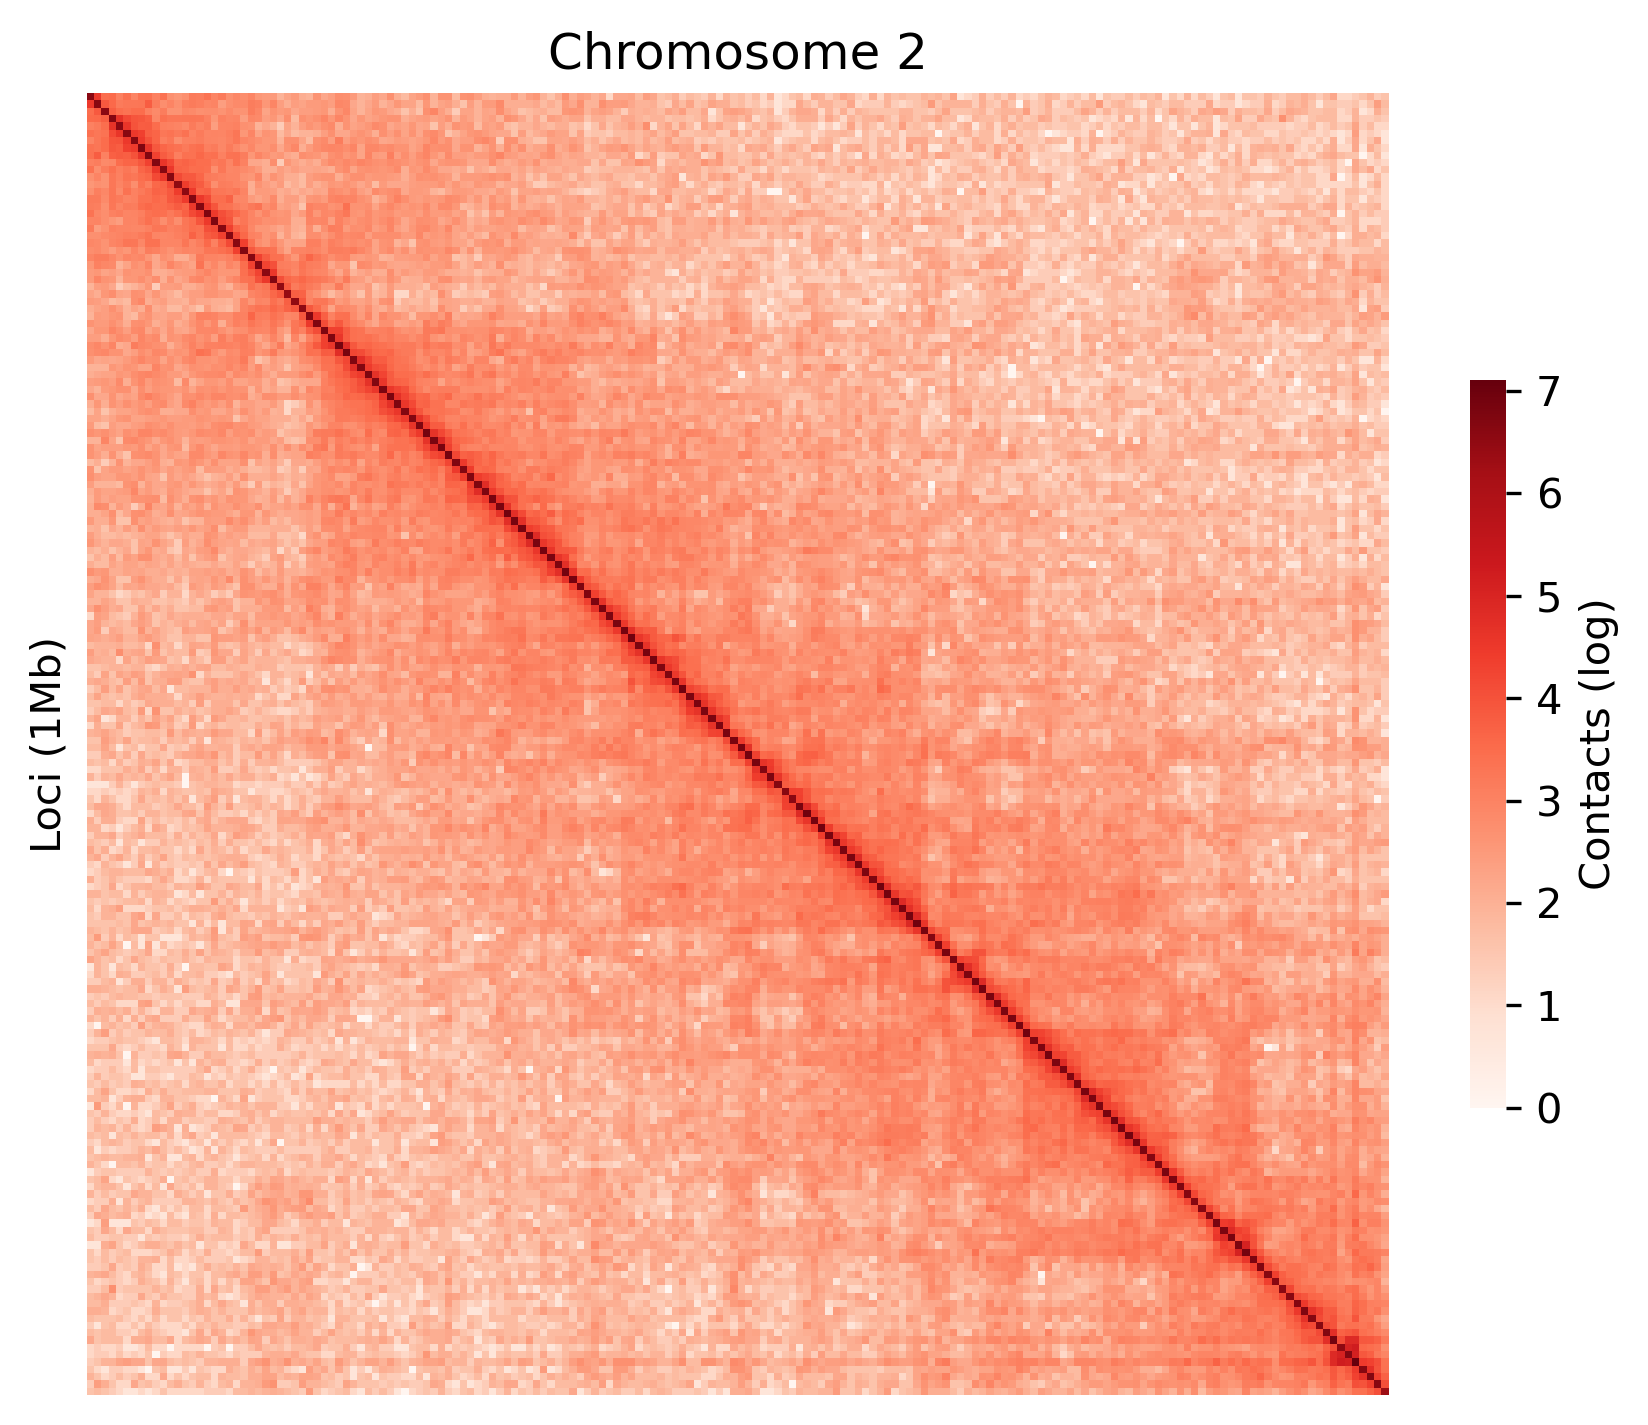

In [5]:
A = matrix.clique_expand_incidence(H, zero_diag=False) 
A = A.sort_index(axis=1)
A = A.sort_index(axis=0)

# find and report repeat regions
outlier_indices = matrix.find_outlier_row_indices(A, threshold=1.5)
print(f"'{outlier_indices=}'")

# drop outliers
A = A.drop(outlier_indices, axis=1)
A = A.drop(outlier_indices, axis=0)

print(f"{A.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 7

sns.heatmap(np.log1p(A), 
            cmap='Reds',
            square=True, 
            cbar_kws={'shrink' : 0.45, 'label' : 'Contacts (log)'},
           )

plt.yticks([])
plt.xticks([])

plt.title(f"Chromosome {chromosomes[0]}")
plt.ylabel(f"Loci (1Mb)")
plt.xlabel("")

# Centrality

nodes.shape=(178, 5)
len(core_nodes)=45


,local_bin,node_centrality,zscores,node_centrality_norm,core,bin_number
173,178,0.005662,1.877631,1.000000,True,178.0
2,6,0.005647,1.253244,0.951422,True,6.0
90,94,0.005643,1.068247,0.937029,True,94.0
46,50,0.005642,1.031550,0.934174,True,50.0
66,70,0.005642,1.030956,0.934128,True,70.0
32,36,0.005642,1.011627,0.932624,True,36.0
17,21,0.005641,0.980541,0.930206,True,21.0
67,71,0.005641,0.975885,0.929844,True,71.0
74,78,0.005640,0.951807,0.927970,True,78.0
108,113,0.005640,0.948844,0.927740,True,113.0


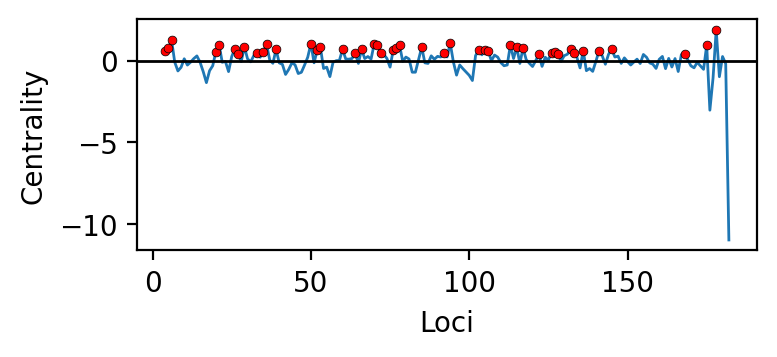

In [6]:
def get_core(H, outlier_indices, function='log-exp', q=0.75, maxiter=1000):
    """
    Calculates nonlinear eigenvector centrality and related metrics.

    Args:
        H: The adjacency matrix (pandas DataFrame).
        outlier_indices: List of indices to drop from H.
        function: Nonlinear function for centrality calculation (default: 'log-exp').
        q: Quantile threshold for defining 'core' nodes (default: 0.75).
        maxiter: Maximum iterations for centrality calculation.

    Returns:
        pandas.DataFrame: A DataFrame with node information and centrality metrics.
    """
    
    # Remove outliers and zero-sum columns (without explicit checks)
    Hhat = H.drop(outlier_indices).loc[:, (H.sum(axis=0) != 0)]

    # Calculate centrality using NetworkX
    nodes_cent, _ = central.nonlinear_eigenvector_centrality(
        Hhat, 
        function=function, 
        maxiter=maxiter,
    )

    # Create DataFrame with results
    nodes = pd.DataFrame({
        'local_bin': Hhat.index,
        'node_centrality': nodes_cent,
        'zscores': stats.zscore(nodes_cent),
        'node_centrality_norm': ut.min_max(nodes_cent),  # Assuming you have ut.min_max elsewhere
        'core' : nodes_cent >= np.quantile(nodes_cent, q),
    })

    return nodes


nodes = get_core(H, outlier_indices)
print(f"{nodes.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 1.5

sns.lineplot(
    data=nodes,
    x='local_bin',
    y='zscores',
    lw=1,
)

sns.scatterplot(
    data=nodes[nodes['core']],
    x='local_bin',
    y='zscores',
    s=10,
    c='r',
    ec='k', 
    zorder=5,
)

plt.axhline(y=0, lw=1, c='k')

plt.ylabel('Centrality')
plt.xlabel('Loci')

core_nodes = sorted(nodes[nodes['core']]['local_bin'].values)
print(f"{len(core_nodes)=}")

nodes = nodes.sort_values(by='zscores', ascending=False)
nodes['bin_number'] = nodes['local_bin'].astype(float)

nodes.head(10)

In [7]:
# break

# Centrality and clique-expanded eigenvector

'outlier_indices=[99]'
A.shape=(178, 178)
pc_1.shape=(178,) nodes.shape=(178, 6)
Correlation: r=-0.206, (pval=0.00576)


Text(0, 0.5, 'Magnitude')

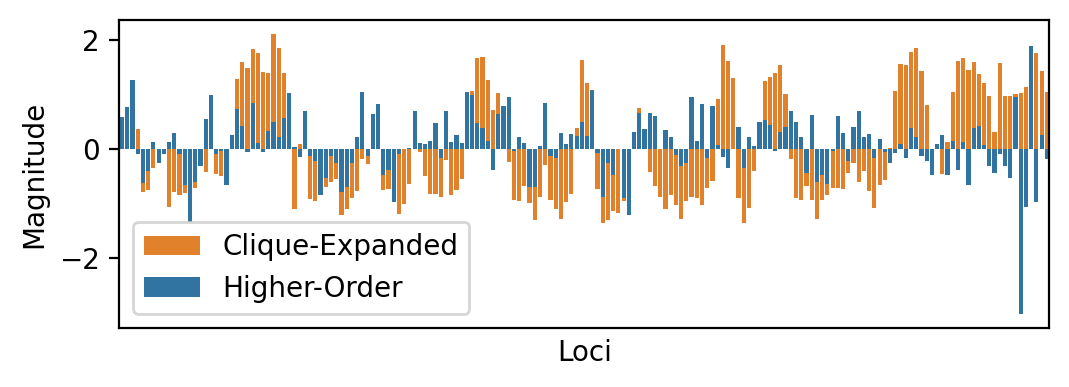

In [8]:
A = matrix.clique_expand_incidence(H, zero_diag=False) 
A = A.sort_index(axis=1)
A = A.sort_index(axis=0)

# find and report repeat regions
outlier_indices = matrix.find_outlier_row_indices(A, threshold=3)
print(f"'{outlier_indices=}'")

# drop outliers
A = A.drop(outlier_indices, axis=1)
A = A.drop(outlier_indices, axis=0)

A = matrix.normalize_oe(matrix.normalize_kr(A).todense())
A = np.asarray(A)

print(f"{A.shape=}")

pca = PCA(n_components=10)
pca.fit(A)
X_pca = pca.transform(A)
pc_1 = stats.zscore(X_pca[:, 0]) 

print(f"{pc_1.shape=} {nodes.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 2

sns.barplot(
    x=range(4, len(X_pca)+4),
    y=pc_1,
    color='C1',
    label='Clique-Expanded',
    # alpha=0.6,
)


sns.barplot(
    data=nodes.head(177), 
    x='local_bin',
    y='zscores',
    label='Higher-Order',
)

r, pval = scipy.stats.pearsonr(pc_1, nodes['zscores'].values)
print(f"Correlation: {r=:.3f}, (pval={pval:.5f})")

plt.xticks([])
plt.xlabel('Loci')
plt.ylabel('Magnitude')

# Define the core
### nodes with high centrality

In [9]:
"""
1. Nodes with high centrality
2. Higher-order contacts
3. Non-empty hyperedges (this is hanmdled in the get_core function)
"""
nodes = get_core(H, outlier_indices)
node_idx = nodes[nodes['core'] == True]['local_bin'].values

core = H.copy()
core = core.iloc[node_idx, :]
core = core.loc[:, (core.sum(axis=0) > 2)]

print(f"{core.shape=}")

core.shape=(45, 1194)


Text(0.5, 302.6666666666665, '')

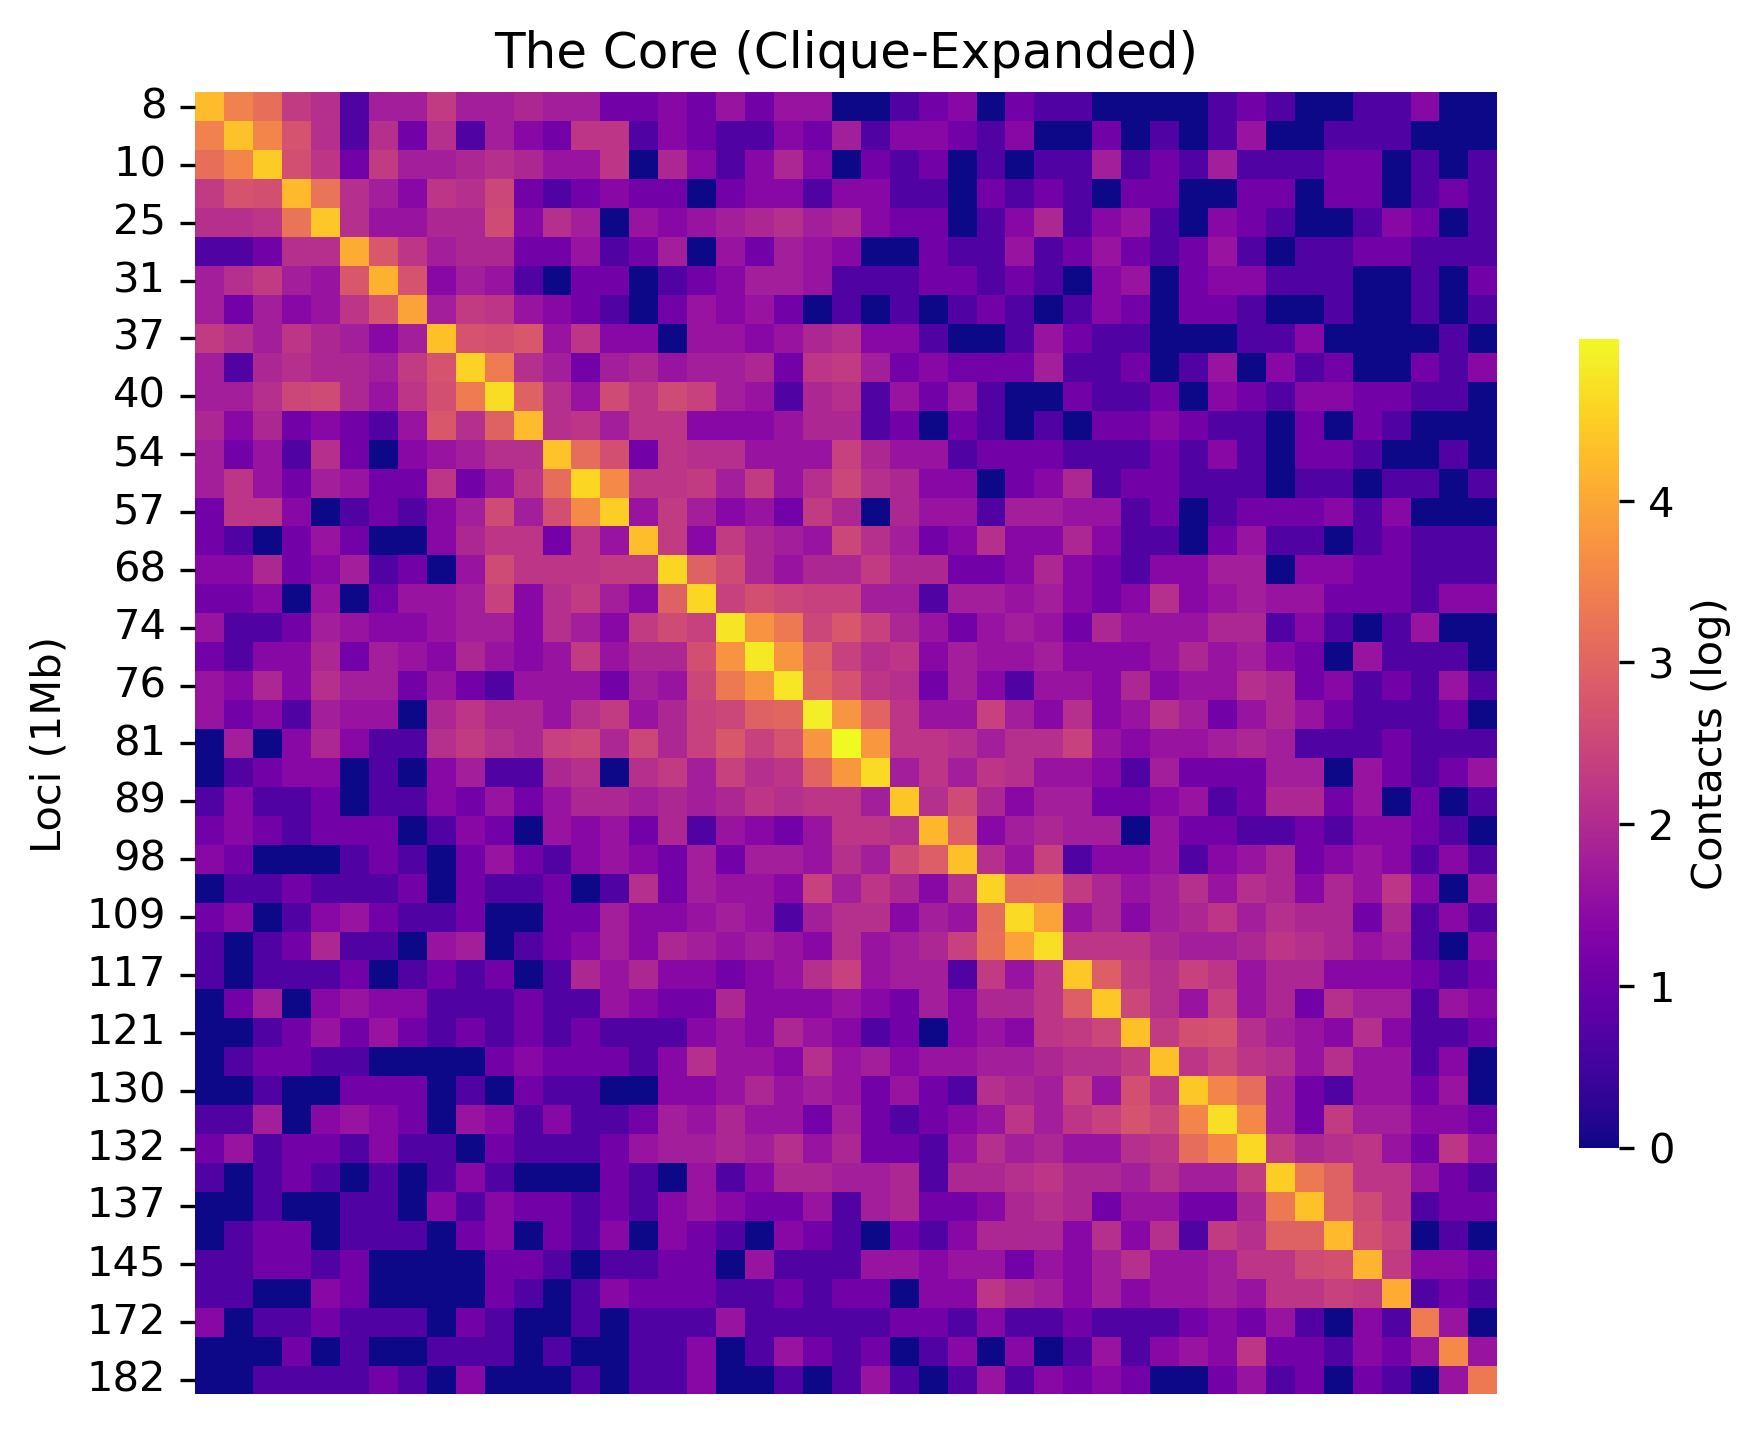

In [10]:
Acore = matrix.clique_expand_incidence(core, zero_diag=False) 
Acore = Acore.sort_index(axis=1)
Acore = Acore.sort_index(axis=0)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 7

sns.heatmap(
    np.log1p(Acore), 
    cmap='plasma',
    square=True, 
    cbar_kws={'shrink' : 0.5, 'label' : 'Contacts (log)'},
)

# plt.yticks([])
plt.xticks([])

plt.title('The Core (Clique-Expanded)')
plt.ylabel("Loci (1Mb)")
plt.xlabel("")

# plot the incidence matrix

Text(0.5, 1.0, 'Chromosome 2')

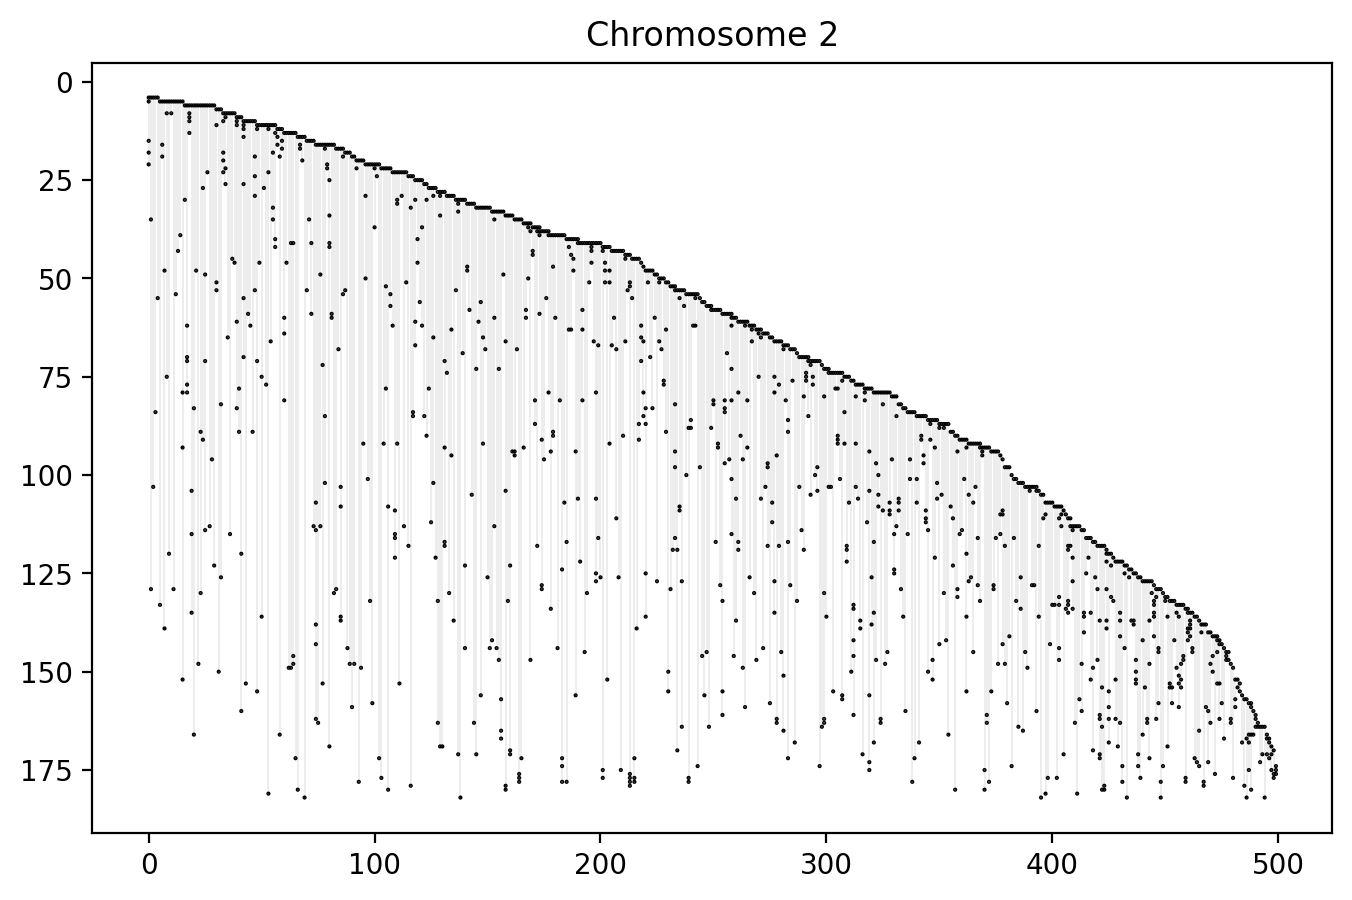

In [11]:
node_params = {
    's' : 1,
    'ec' : 'k',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.1,
    'alpha' : 0.5,
    'zorder' : 1,
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5

sample_size = 500
plt2.plot_incidence(ut.sort_by_lowest_index(H.drop(outlier_indices).T.sample(sample_size).T), 
                    node_color='k',
                    node_params=node_params,
                    line_params=line_params)

plt.title(f"Chromosome {chromosomes[0]}")

Text(0.5, 1.0, 'The Core of Chromosome 2')

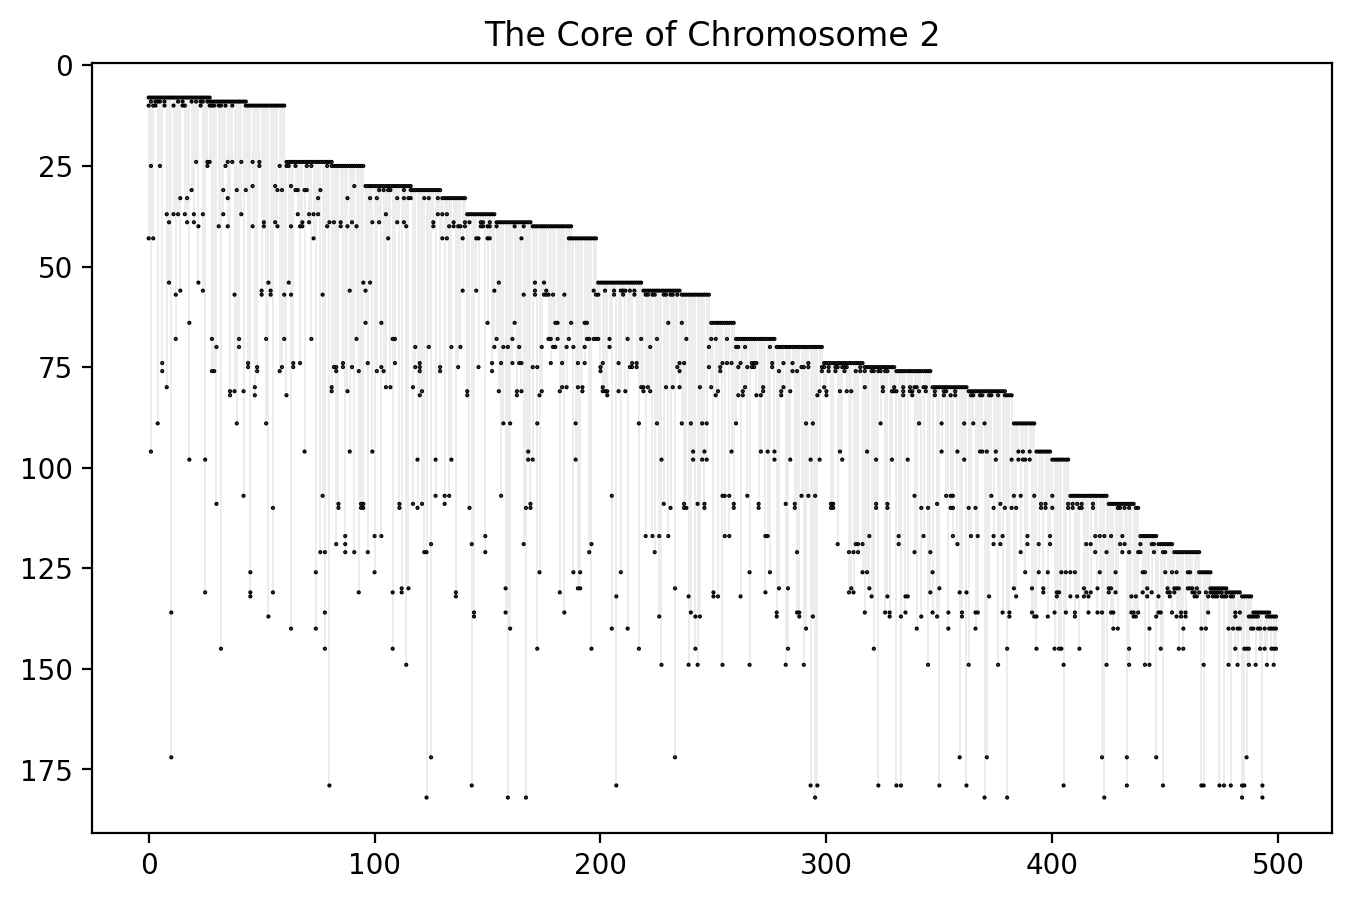

In [12]:
node_params = {
    's' : 1,
    'ec' : 'k',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.1,
    'alpha' : 0.5,
    'zorder' : 1,
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5

sample_size = 500
plt2.plot_incidence(ut.sort_by_lowest_index(core.T.sample(sample_size).T), 
                    node_color='k',
                    node_params=node_params,
                    line_params=line_params)

plt.title(f"The Core of Chromosome {chromosomes[0]}")

# Histone Marks

In [13]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Load Genes

In [ ]:
fpath = "../../resources/genes.parquet"

LOG_EXPRESSION_THRESHOLD = 2

gdf = pd.read_parquet(fpath)
gdf = gdf[gdf['is_gene']]
gdf = gdf[gdf['is_pt_gene']]

gdf = gdf[gdf['Chromosome'].isin(chromosomes)]
gdf['local_bin'] = gdf['midpoint'].apply(lambda x: np.ceil(x // resolution))
gdf['in_core'] = gdf['local_bin'].isin(core.index)

gdf['expressed_above_threshold'] = gdf['expression_log'] > LOG_EXPRESSION_THRESHOLD

print(f"{gdf.shape=}")
gdf.head()

In [ ]:
core_genes = gdf[gdf['in_core'] & gdf['is_expressed']]
print(f"{core_genes.shape=}")

core_genes = core_genes.sort_values(by='expression', ascending=False)
core_genes[[
    'gene_name', 
    'is_tf', 
    'mESC_panglaoDB_marker',
    'mESC_panglaoDB_marker',
]].head(15)

In [ ]:
core_genes[core_genes['mESC_panglaoDB_marker']]

In [ ]:
genes_by_bin = gdf.groupby('local_bin').agg(
    n_genes = ('gene_name', 'nunique'),
    expressed_above_threshold = ('expressed_above_threshold', 'sum'),
    n_pangloa = ('mESC_panglaoDB_marker', 'sum'),
    n_go = ('mESC_GO_marker', 'sum'),
    mean_expression = ('expression', 'mean'),
    mean_log_expression = ('expression_log', 'mean'),
).reset_index()

genes_by_bin = pd.merge(genes_by_bin, nodes, 
                       how='left')

genes_by_bin = genes_by_bin.sort_values(by='mean_expression', ascending=False)
genes_by_bin.head(10)

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()

columns = {
    'n_genes' : 'Genes',
    'expressed_above_threshold' : 'Expressed Genes',
    'mean_expression' : 'Mean Expression',
}


for i, (column, label) in enumerate(columns.items()):
    
    sns.boxplot(data=genes_by_bin,
                x='core',
                y=column,
                hue='core',
                showfliers=False,
                ax=axs[i],
                legend=False,
               )
    axs[i].set_xlabel("Core")
    axs[i].set_ylabel(label)
    
plt.tight_layout()

# Load Hi-C

In [ ]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/poreC/data/f1219_population_hic/4DNFICF9PA9C.mcool"

chrom = "chr2"
clr = cooler.Cooler(f'{fpath}::resolutions/{1000000}')
Ahic = clr.matrix(balance=False).fetch(str(chrom))[:]
Ahic = np.nan_to_num(Ahic)
print(f"{Ahic.shape=}")

# drop the telomere
print(f"{Ahic.shape=}")

Ahic = pd.DataFrame(Ahic)
Ahic.head()

In [ ]:
q = 0.75
Ahic_norm = matrix.normalize_oe(matrix.normalize_kr(Ahic.to_numpy()[3:, 3:]).todense())
vhic, whic = np.linalg.eigh(Ahic_norm)

ab_hic = np.array(whic[:, -1]).ravel()
ab_hic = ab_hic - ab_hic.mean()

hic_nodes = pd.DataFrame({
    'local_bin' : Ahic.index[3:],
    'centrality' : ab_hic
})

hic_nodes['core'] = hic_nodes['centrality'] >= np.quantile(hic_nodes['centrality'], q)
hic_nodes = hic_nodes.sort_values(by='centrality', ascending=False)
hic_nodes['pore_core'] = hic_nodes['local_bin'].isin(core.index)

overlap = set(core.index) & set(hic_nodes[hic_nodes['core']]['local_bin'].values) 
print(f"Pore-C Core: {len(core.index)}")
print(f"Hi-C Core: {len(hic_nodes[hic_nodes['core']]['local_bin'].values)}")
print(f"{overlap=} ({len(overlap)} overlapping)")

hic_nodes.head()

In [ ]:
break

In [ ]:
sns.barplot(
    data=hic_nodes,
    x='local_bin',
    y='centrality',
)


In [ ]:
# Core from Hi-C
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 7

sns.heatmap(
    np.log1p(Ahic.loc[core.index, core.index]), 
    cmap='plasma',
    square=True, 
    cbar_kws={'shrink' : 0.5, 'label' : 'Contacts (log)'},
)

# plt.yticks([])
plt.xticks([])

plt.title('The Core (from Hi-C)')
plt.ylabel("Loci (1Mb)")
plt.xlabel("")


In [ ]:
break

In [ ]:
break

In [ ]:
core = H.copy()
core = core.iloc[node_idx, edge_idx].copy()
core = core.loc[:, (core.sum(axis=0) != 0)]

print(f"{core.shape=}")

In [ ]:
core.sum(axis=1).min()

In [ ]:
core.sum(axis=0).min()

In [ ]:
break

In [ ]:
Hhat = H.drop(outlier_indices).copy()

# subset all hyperedges with at least 1 node in the core
core_edges = Hhat.loc[core_nodes].sum(axis=0) > 0
core = Hhat.loc[:, core_edges].copy()
core = core.loc[:, (core.sum(axis=0) != 0)]
print(f"{core.shape=}")


In [ ]:
break

In [ ]:
Acore = matrix.clique_expand_incidence(core, zero_diag=False) 
Acore = Acore.sort_index(axis=1)
Acore = Acore.sort_index(axis=0)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 7

sns.heatmap(np.log1p(Acore), 
            cmap='plasma',
            square=True, 
            cbar_kws={'shrink' : 0.5, 'label' : 'Contacts (log)'},
           )

# plt.yticks([])
plt.xticks([])

plt.title('The Core (Clique-Expanded)')
plt.ylabel("Loci (1Mb)")
plt.xlabel("")

In [ ]:
break

In [ ]:
break

# Load genes

In [ ]:
fpath = "../../resources/genes.parquet"

LOG_EXPRESSION_THRESHOLD = 2

gdf = pd.read_parquet(fpath)
gdf = gdf[gdf['is_gene']]
gdf = gdf[gdf['is_pt_gene']]

gdf = gdf[gdf['Chromosome'].isin(chromosomes)]
gdf['local_bin'] = gdf['midpoint'].apply(lambda x: np.ceil(x // resolution))

gdf['expressed_above_threshold'] = gdf['expression_log'] > LOG_EXPRESSION_THRESHOLD

print(f"{gdf.shape=}")
gdf.head()

In [ ]:
genes_by_bin = gdf.groupby('local_bin').agg(
    n_genes = ('gene_name', 'nunique'),
    expressed_above_threshold = ('expressed_above_threshold', 'sum'),
    n_pangloa = ('mESC_panglaoDB_marker', 'sum'),
    n_go = ('mESC_GO_marker', 'sum'),
    mean_expression = ('expression', 'mean'),
    mean_log_expression = ('expression_log', 'mean'),
).reset_index()

genes_by_bin = genes_by_bin.sort_values(by='mean_expression', ascending=False)
genes_by_bin.head(10)

In [ ]:
genes_by_bin = genes_by_bin.sort_values(by='n_pangloa', ascending=False)
genes_by_bin.head(10)

In [ ]:
gdf[gdf['mESC_panglaoDB_marker']]

In [ ]:
gdf['local_bin'].min()

# choose core by gene expression and fiedler value

In [ ]:
res = []

for expression_threshold in sorted(genes_by_bin['mean_expression'].unique()):
    tmp = genes_by_bin[genes_by_bin['mean_expression'] >= expression_threshold]
    node_idx = tmp['local_bin'].astype(int).values
    node_idx = node_idx[node_idx > 35]

    core = H.loc[node_idx]

    # remove non-existant edges
    core = core.loc[:, (core.sum(axis=0) != 0)]

    if core.empty:
        continue
        
    try:
        L = matrix.normalized_hypergraph_laplacian(core).todense()        
        eigenvalues, eigenvectors = np.linalg.eigh(L)
        fiedler_number = eigenvalues[1]
    except:
        fiedler_number = None
        
    row = {
        'expression_threshold' : expression_threshold,
        'n_nodes' : len(node_idx),
        'core_nodes' : node_idx,
        'fiedler_number' : fiedler_number,
    }
    res.append(row)
    
res = pd.DataFrame(res)
res = res.sort_values(by='expression_threshold', ascending=False)
res.head(10)

In [ ]:
res.tail(10)

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2

sns.lineplot(data=res,
             x='expression_threshold',
             y='fiedler_number',
             lw=1,)

plt.ylabel('Fiedler Number')
plt.xlabel('Expression Threshold (CPM)')

In [ ]:
break

In [ ]:
X1 0 0
X2 1 1
X3 0 0
X4 1 0
X5 1 1

# ONLY
X2 1 1
X5 1 1

# INCLUDED
X2 1 1
X4 1 0
X5 1 1





# Centrality

In [ ]:
function = 'log-exp'
# function = 'linear'


Hhat = H.drop(outlier_indices).copy()
Hhat = Hhat.loc[:, (Hhat.sum(axis=0) != 0)]
print(f"{H.shape=} {Hhat.shape=}") 

nodes, _ = central.nonlinear_eigenvector_centrality(Hhat.to_numpy(), 
                                                    function=function, 
                                                    maxiter=10000)

nodes = pd.DataFrame({
    'local_bin' : Hhat.index,
    'node_centrality' : nodes,
    'node_centrality_norm' : ut.min_max(nodes),
    
})


"""
MERGE IN GENE INFORMATION
"""

nodes = pd.merge(nodes, genes_by_bin, 
                 how='left',
                 left_on='local_bin',
                 right_on='local_bin',
                )

print(f"{nodes.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 1.5

sns.lineplot(
    data=nodes,
    x='local_bin',
    y='node_centrality_norm',
    lw=1,
)

plt.ylabel('Centrality')
plt.xlabel('Loci')

nodes = nodes.sort_values(by='node_centrality', ascending=False)

nodes.head(10)

In [ ]:
nodes.tail()

In [ ]:
nodes[['node_centrality_norm', 'n_genes', 'expressed_above_threshold', 'mean_expression']].corr()

In [ ]:
break

# Maximize the Fiedler Value

In [ ]:
"""choosing from node centralities only"""

res = []

for n_t in nodes['node_centrality_norm'].values:
    
    node_idx = sorted(nodes[nodes['node_centrality_norm'] >= n_t]['local_bin'].values)
    core = H.loc[node_idx]

    # remove non-existant edges
    core = core.loc[:, (core.sum(axis=0) != 0)]

    if core.empty:
        continue
        
    try:
        L = matrix.normalized_hypergraph_laplacian(core).todense()        
        eigenvalues, eigenvectors = np.linalg.eigh(L)
        fiedler_number = eigenvalues[1]
    except:
        fiedler_number = None

    row = {
        'node_thresh' : n_t,
        'n_nodes' : len(node_idx),
        'core_nodes' : node_idx,
        'fiedler_number' : fiedler_number,
    }
    res.append(row)
    
res = pd.DataFrame(res)
res = res.sort_values(by='fiedler_number', ascending=False)
res.head(10)

In [ ]:
break

In [ ]:
df = []

resolution = 1e6

columns = [
    'read_name',
    'align_id',
    'chrom', 
    'ref_start', 
    'ref_end',
    'is_mapped',
]

for fpath in file_list:
    basename = os.path.basename(fpath).split(".")[0]
    tmp = pd.read_parquet(fpath, columns=columns)
    
    # only mapped monomers
    tmp = tmp[tmp['is_mapped']]
    
    # only chromosomal contigs (no unplaced contigs)
    tmp = tmp[tmp['chrom'].isin(chroms['chrom'].values)]
    
    # compute the midpoint of each alignment
    tmp['local_position'] = ((tmp['ref_end'] - tmp['ref_start']) // 2) + tmp['ref_start']
    
    # convert local coordinates to global bin loci at some resolution
    tmp['chrom_start'] = tmp['chrom'].map(chrom_starts)
    tmp['global_position'] = tmp['chrom_start'] + tmp['local_position']
    tmp['global_bin'] = tmp['global_position'].apply(lambda x: np.ceil(x / resolution))
    tmp = tmp[tmp['global_bin'].notna()]
    
    tmp['basename'] = basename
    
    # drop duplicate bins per read (only unique monomners in the contact)
    tmp = tmp.drop_duplicates(subset=['read_name', 'global_bin'])
    tmp['order'] = tmp.groupby('read_name')['global_bin'].transform('nunique')
    
    # drop all singletons
    tmp = tmp[tmp['order'] > 1]
    
    print(basename, tmp.shape)    
    df.append(tmp)

df = pd.concat(df)
print(f"{df.shape=}")
df['global_bin'] = df['global_bin'].astype(int)

df.head()

# Load gene information

In [ ]:
"load pangloadb"
fpath = "../../resources/mESC_pangloadb.csv"
pdf = pd.read_csv(fpath)
print(f"{pdf.shape=}")
print(f"{pdf['gene_name'].nunique()=}")
print()

""" load gene ontology annotations """
fpath = "../../resources/stem_cell_population_maintenance.csv"
godf = pd.read_csv(fpath)
godf['gene_name'] = godf['gene_name'].str.upper()
print(f"{godf.shape=}")
print(f"{godf['gene_name'].nunique()=}")
print()

""" load gene expression """
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/rna/expression.parquet"
exdf = pd.read_parquet(fpath)

tpm_columns = [x for x in exdf.columns if "TPM" in x]
exdf['expression_mean'] = exdf[tpm_columns].mean(axis=1)
exdf['gene_name'] = exdf['gene_name'].str.upper()
express_map = dict(zip(exdf['gene_name'].values, exdf['expression_mean'].values))

exdf = exdf[exdf['expression_mean'] > 0]
print(f"{exdf.shape=}")
print(f"{exdf['gene_name'].nunique()=}")

""" Gene locations """
resolution = 1000000
chromosome = "1"

gene_table_path = "/scratch/indikar_root/indikar1/shared_data/higher_order/reference/gene_table.parquet"
gdf = pd.read_parquet(gene_table_path)

gdf['gene_name'] = gdf['gene_name'].str.upper()

gdf = gdf[gdf['Chromosome'] == "1"]
gdf['bin'] = gdf['midpoint'].apply(lambda x: ut.bin_loci(x, resolution))


gdf['is_gene'] = [True] * len(gdf)
gdf['is_pt_gene'] = gdf['gene_biotype'] == 'protein_coding'
gdf['is_expressed'] = gdf['gene_name'].isin(exdf['gene_name'].values)
gdf['expression'] = gdf['gene_name'].map(express_map)
gdf['expression'] = gdf['expression'].fillna(0)
gdf['expression_log'] = np.log1p(gdf['expression'])
gdf['mESC_panglaoDB_marker'] = gdf['gene_name'].isin(pdf['gene_name'].values)
gdf['mESC_GO_marker'] = gdf['gene_name'].isin(godf['gene_name'].values)

gdf.head()

# Load population Pore-C Data

In [ ]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/population_pore_c/chr1_1000000_incidence.parquet"

df = pd.read_parquet(fpath)
print(f"{df.shape=}")
df.head()

# Compute centrality

In [ ]:
reload(central)

nodes = []
edges = []

measures = [
    'linear',
    'log-exp', 
    'max',
]

for func in measures:
    ncent, ecent = central.nonlinear_eigenvector_centrality(df.to_numpy(), 
                                                            function=func, 
                                                            maxiter=1000)
    ncent = ut.min_max(ncent)
    ecent = ut.min_max(ecent)
    nodes.append(pd.DataFrame({func : ncent,}, index=df.index))
    edges.append(pd.DataFrame({func : ecent,}, index=df.columns))
    
nodes = pd.concat(nodes, axis=1).reset_index()
edges = pd.concat(edges, axis=1).reset_index()

print(f"{nodes.shape=}")
print(f"{edges.shape=}")